<a href="https://www.kaggle.com/code/dascient/auto-recruitment-recruitment-as-a-service-araas?scriptVersionId=264187169" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Auto-Recruitment (ARaaS) — Minimal, Capable, Kaggle-Ready Notebook
## What you get
- Zero-setup imports (pandas, numpy, plotly, scikit-learn).  
- Auto-load from `/kaggle/input` if present; otherwise, a synthetic demo dataset is generated.  
- Interactive Plotly charts (time series, group-by bar, funnel).  
- Lightweight candidate–job text matching via TF-IDF cosine similarity.  
- Optional HTML export of key charts for sharing.

DaScient, LLC | Proprietary

In [14]:
## 1) Imports & Config
import os
import json
import math
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)  
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

pd.set_option("display.max_colwidth", 200)

import plotly.io as pio
pio.templates.default = "plotly_white"

print("Versions -> pandas:", pd.__version__, "| numpy:", np.__version__)

Versions -> pandas: 1.3.5 | numpy: 1.21.6


## [See part 2 here.](https://www.kaggle.com/code/dascient/auto-recruitment-as-a-service-araas-2-0)

In [15]:
# Data Load
CANDIDATES_CSV = None
JOBS_CSV       = None
APPS_CSV       = None

def try_read_csv(path):
    try:
        if path and os.path.exists(path):
            return pd.read_csv(path)
    except Exception as e:
        print(f"Could not read {path}: {e}")
    return None

candidates = try_read_csv(CANDIDATES_CSV)
jobs = try_read_csv(JOBS_CSV)
apps = try_read_csv(APPS_CSV)

if candidates is None or jobs is None or apps is None:
    # synthetic fallback
    rng = np.random.default_rng(42)
    roles = ["Data Scientist", "ML Engineer", "Data Analyst", "MLOps Engineer"]
    locations = ["SF", "NYC", "Remote", "London"]
    sources = ["LinkedIn", "Referral", "Indeed", "GitHub"]
    stages = ["Applied", "Screen", "Interview", "Offer", "Hired"]

    jobs = pd.DataFrame({
        "job_id": range(1001, 1009),
        "role": rng.choice(roles, 8),
        "location": rng.choice(locations, 8),
        "description": rng.choice([
            "NLP, embeddings, LLM orchestration, Python",
            "Time-series forecasting, SQL, BI, experimentation",
            "Computer vision, PyTorch, MLOps, data pipelines",
            "Recommenders, Spark, distributed training"
        ], 8)
    })

    skills_pool = [
        "Python, pandas, scikit-learn, SQL, Plotly",
        "PyTorch, TensorFlow, MLOps, Docker, Airflow",
        "NLP, transformers, embeddings, retrieval",
        "Statistics, experimentation, causal inference",
        "Computer vision, OpenCV, detection, segmentation"
    ]
    N = 250
    candidates = pd.DataFrame({
        "candidate_id": range(5001, 5001+N),
        "location": rng.choice(locations, N),
        "years_experience": rng.integers(0, 12, size=N),
        "skills": rng.choice(skills_pool, N),
        "resume_text": rng.choice([
            "Built NLP pipelines with transformers and vector search.",
            "Designed forecasting models and A/B testing frameworks.",
            "Deployed CV models with MLOps best practices.",
            "Implemented recommenders with Spark and feature stores."
        ], N)
    })

    def random_date(start="2024-01-01", end="2025-09-01"):
        s = pd.to_datetime(start).value//10**9
        e = pd.to_datetime(end).value//10**9
        t = rng.integers(s, e)
        return pd.to_datetime(t, unit="s")

    M = 600
    apps = pd.DataFrame({
        "application_id": range(9001, 9001+M),
        "candidate_id": rng.choice(candidates["candidate_id"], M),
        "job_id": rng.choice(jobs["job_id"], M),
        "source": rng.choice(sources, M, p=[0.45, 0.25, 0.20, 0.10]),
        "stage": rng.choice(stages, M, p=[0.45, 0.25, 0.20, 0.07, 0.03]),
        "stage_timestamp": [random_date() for _ in range(M)],
        "salary": rng.normal(135000, 25000, size=M).round(0)
    })

apps["stage_timestamp"] = pd.to_datetime(apps["stage_timestamp"], errors="coerce")
apps = apps.dropna(subset=["stage_timestamp"]).copy()

In [16]:
# Overview
print("Candidates:", candidates.shape)
print("Jobs:", jobs.shape)
print("Applications:", apps.shape)

display(apps.head(3))
display(jobs.head(3))
display(candidates.head(3))

Candidates: (250, 5)
Jobs: (8, 4)
Applications: (600, 7)


,application_id,candidate_id,job_id,source,stage,stage_timestamp,salary
0,9001,5206,1005,Referral,Hired,2024-08-26 19:58:57,125499.0
1,9002,5014,1008,GitHub,Interview,2024-08-22 06:32:01,82520.0
2,9003,5020,1005,GitHub,Applied,2024-01-02 20:09:02,155989.0


,job_id,role,location,description
0,1001,Data Scientist,SF,"Computer vision, PyTorch, MLOps, data pipelines"
1,1002,MLOps Engineer,SF,"NLP, embeddings, LLM orchestration, Python"
2,1003,Data Analyst,Remote,"Recommenders, Spark, distributed training"


,candidate_id,location,years_experience,skills,resume_text
0,5001,London,5,"PyTorch, TensorFlow, MLOps, Docker, Airflow",Implemented recommenders with Spark and feature stores.
1,5002,Remote,5,"PyTorch, TensorFlow, MLOps, Docker, Airflow",Implemented recommenders with Spark and feature stores.
2,5003,NYC,5,"Computer vision, OpenCV, detection, segmentation",Designed forecasting models and A/B testing frameworks.


In [17]:
# Time Series (Interactive) 
init_notebook_mode(connected=True)  
apps_daily = apps.assign(date=apps["stage_timestamp"].dt.date).groupby("date").size().reset_index(name="applications")

fig_ts = px.line(
    apps_daily, x="date", y="applications",
    title="Applications per Day",
    markers=True
)
fig_ts.update_layout(
    xaxis=dict(rangeslider=dict(visible=True), type="date"),
    hovermode="x unified"
)
fig_ts.show()

# Matching Algorithm
[Article](https://skillate.com/blog/how-does-ml-based-job-resume-matching-algorithm-work-2/)

Matching Algorithm is the AI-powered algorithm to compute the matching score between a job and a resume. The algorithm (powered by the Deep Neural Network) uses multiple matching signals that broadly include:

**Experience**
Industry
Years of Experience
Title or Designations on three layers - based on title, role, and role category.
Seniority Level Matching.
Example: CTO of a 25 members company and having five years of experience doesn't mean he is qualified for VP Technology in any Multinational Companies.

**Education**
College Relevance - according to the requirement mentioned in the job description else, no biases in college preference.
Degree
Major - which is closely related to the job skills requirements.

**Skills**
Functional Skills Example: JAVA, Enterprise Sales, Invoice Processing, etc.
Behavioral Skills Example: Critical Thinking, Communication Skills, etc.
Recent Candidate Skills
The Matching Algorithm uses the above matching variables in computing three scores - Skill, Education, and Experience. And according to the weights (which can be configured by the organization) given help in calculating Overall Matching Score.

In [19]:
from IPython.display import clear_output
!pip install openpyxl
clear_output()
# read in data
interviews = pd.read_excel('/kaggle/input/interviews/Interviews.xlsx',header=0)
resumes = pd.read_csv('/kaggle/input/resume-dataset/UpdatedResumeDataSet.csv',header=0)

# EDA

In [21]:
# Grouped Dropdown
apps_jobs = apps.merge(jobs[["job_id", "role", "location"]], on="job_id", how="left")

def make_group_bar(group_col):
    agg = apps_jobs.groupby(group_col).size().reset_index(name="count").sort_values("count", ascending=False)
    return px.bar(agg, x=group_col, y="count", title=f"Applications by {group_col.capitalize()}", text="count")

fig_bar = make_group_bar("role")
figs = {
    "Role": make_group_bar("role"),
    "Location": make_group_bar("location"),
    "Source": make_group_bar("source")
}

fig_bar.update_layout(
    updatemenus=[dict(
        buttons=[
            dict(label="Role", method="update",
                 args=[{"x":[figs["Role"].data[0].x], "y":[figs["Role"].data[0].y]}, {"title":"Applications by Role"}]),
            dict(label="Location", method="update",
                 args=[{"x":[figs["Location"].data[0].x], "y":[figs["Location"].data[0].y]}, {"title":"Applications by Location"}]),
            dict(label="Source", method="update",
                 args=[{"x":[figs["Source"].data[0].x], "y":[figs["Source"].data[0].y]}, {"title":"Applications by Source"}]),
        ],
        direction="down",
        x=0.01, y=1.15
    )]
)
fig_bar.show()

In [20]:
interviews#.Experience[0]

,Unnamed: 0,index,ID,Date,Titles,Company,Experience,Upvotes,URLS
0,0,0,420303,2020-05-29,Find the K closest points to origin using Priority Queue - GeeksforGeeks,Amazon,"Given a list of n points on 2D plane, the task is to find the K (k < n) closest points to the origin O(0, 0). Note: The distance between a point P(x, y) and O(0, 0) using the standard Euclidean D...",3,https://www.geeksforgeeks.org/find-the-k-closest-points-to-origin-using-priority-queue/
1,1,1,417918,2020-05-26,Amazon Interview Experience | SDE (1.5 Year Experienced) - GeeksforGeeks,Amazon,"Round 1 – Online Coding Round on Amcat Platform: 1) Top N competitors similar to this https://leetcode.com/discuss/interview-question/460127/ 2) A very similar question to this, the same concept o...",3,https://www.geeksforgeeks.org/amazon-interview-experience-sde-1-5-year-experienced/
2,2,2,415868,2020-05-21,Amazon Scotland Interview Experience - GeeksforGeeks,Amazon,"Amazon Scotland was hiring for the position of SDE-2. I just happened to get knowledge of their opportunities from a friend. I had applied, but did not really think about getting shortlisted. Howe...",1,https://www.geeksforgeeks.org/amazon-scotland-interview-experience/
3,3,3,412077,2020-05-14,AWS Cloud Support Associate Interview Experience - GeeksforGeeks,Amazon,Hi everyone. I got placed as Cloud Support Associate at AWS Bangalore in November 2019. I’d like to share my experience of the entire selection process at AWS. I’ll try my best to make it as infor...,0,https://www.geeksforgeeks.org/aws-cloud-support-associate-interview-experience/
4,4,4,401491,2020-05-09,Print all nodes at distance K from given node: Iterative Approach - GeeksforGeeks,Amazon,"Consider the above-given Tree, For the target node 12. Input: K = 1 Output: 8 10 14 Input: K = 2 Output: 4 20 Input: K = 3 output: 22 Approach: There are generally two cases for the nodes at a...",5,https://www.geeksforgeeks.org/print-all-nodes-at-distance-k-from-given-node-iterative-approach/
...,...,...,...,...,...,...,...,...,...
7763,7763,0,341288,2019-09-03,Societe Generale Internship Interview Experience - GeeksforGeeks,Societe Generale Global Solution,"After that, they shortlisted 40 students and conducted 3 more round of interview. Round 2: This was a Technical round, in this round their focus mainly on my projects and ask the simple question...",0,https://www.geeksforgeeks.org/societe-generale-internship-interview-experience/
7764,7764,1,334184,2019-08-18,Societe Generale Campus Placement Drive - GeeksforGeeks,Societe Generale Global Solution,"Societe Generale was one of the first few companies that visited our campus, students from various streams were eligible for the First Round. Around 300 people gave the online test. Round 1: Onlin...",1,https://www.geeksforgeeks.org/societe-generale-campus-placement-drive/
7765,7765,2,332173,2019-08-09,Societe Generale Interview Experience (Campus Placement) - GeeksforGeeks,Societe Generale Global Solution,"Societe Generale was the first few companies that visited our campus, students from CSE, IT, ECE and EEE were eligible for the online test(Round 1). Around 2200 people gave the test. Round 1:Onlin...",2,https://www.geeksforgeeks.org/societe-generale-interview-experience-campus-placement/
7766,7766,3,138825,2016-08-09,Societe Generale Global Solution Interview Experience | Set 1 - GeeksforGeeks,Societe Generale Global Solution,2nd Round: Group Discussion Topic: Start-Ups are a boon or a bane – made to speak against start-ups. My points – a well-established company gives you job security. Not all start-ups make it big...,0,https://www.geeksforgeeks.org/societe-generale-global-solution-set-1/


In [25]:
# Funnel
stage_order = ["Applied", "Screen", "Interview", "Offer", "Hired"]
stage_counts = (
    apps.assign(stage=pd.Categorical(apps["stage"], categories=stage_order, ordered=True))
        .groupby("stage").size().reset_index(name="count").dropna().sort_values("stage")
)

fig_funnel = go.Figure(go.Funnel(
    y=stage_counts["stage"],
    x=stage_counts["count"],
    textinfo="value+percent initial"
))
fig_funnel.update_layout(title="Recruitment Pipeline Funnel")
fig_funnel.show()

In [27]:
# Lightweight - Job Matching
def rank_candidates_for_text(candidates_df, text, top_k=15):
    docs = candidates_df["resume_text"].fillna("").astype(str).tolist() + [str(text)]
    vec = TfidfVectorizer(ngram_range=(1,2), min_df=1, stop_words="english")
    X = vec.fit_transform(docs)
    job_vec = X[-1]
    cand_mat = X[:-1]
    sims = cosine_similarity(cand_mat, job_vec)
    out = candidates_df.copy()
    out["similarity"] = sims.ravel()
    return out.sort_values("similarity", ascending=False).head(top_k)

JOB_ID_TO_MATCH = jobs.iloc[0]["job_id"]
job_text = jobs.loc[jobs["job_id"] == JOB_ID_TO_MATCH, "description"].astype(str).iloc[0]
top_matches = rank_candidates_for_text(candidates, job_text, top_k=10)

print("Job ID:", JOB_ID_TO_MATCH)
print("Job Text:", job_text)
display(top_matches[["candidate_id", "years_experience", "location", "skills", "similarity"]])

Job ID: 1001
Job Text: Computer vision, PyTorch, MLOps, data pipelines


,candidate_id,years_experience,location,skills,similarity
125,5126,3,SF,"Computer vision, OpenCV, detection, segmentation",0.039196
105,5106,3,Remote,"PyTorch, TensorFlow, MLOps, Docker, Airflow",0.039196
103,5104,8,London,"PyTorch, TensorFlow, MLOps, Docker, Airflow",0.039196
102,5103,8,SF,"PyTorch, TensorFlow, MLOps, Docker, Airflow",0.039196
101,5102,1,Remote,"PyTorch, TensorFlow, MLOps, Docker, Airflow",0.039196
100,5101,10,London,"Statistics, experimentation, causal inference",0.039196
203,5204,0,Remote,"Python, pandas, scikit-learn, SQL, Plotly",0.039196
205,5206,1,SF,"Statistics, experimentation, causal inference",0.039196
91,5092,6,Remote,"Statistics, experimentation, causal inference",0.039196
206,5207,3,NYC,"Statistics, experimentation, causal inference",0.039196


In [33]:
resumes.Resume

0      Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, NaÃ¯ve Bayes, KNN, Random Forest, Decisi...
1      Education Details \r\nMay 2013 to May 2017 B.E   UIT-RGPV\r\nData Scientist \r\n\r\nData Scientist - Matelabs\r\nSkill Details \r\nPython- Exprience - Less than 1 year months\r\nStatsmodels- Expri...
2      Areas of Interest Deep Learning, Control System Design, Programming in-Python, Electric Machinery, Web Development, Analytics Technical Activities q Hindustan Aeronautics Limited, Bangalore - For ...
3      Skills â¢ R â¢ Python â¢ SAP HANA â¢ Tableau â¢ SAP HANA SQL â¢ SAP HANA PAL â¢ MS SQL â¢ SAP Lumira â¢ C# â¢ Linear Programming â¢ Data Modelling â¢ Advance Analytics â¢ SCM Analytic...
4      Education Details \r\n MCA   YMCAUST,  Faridabad,  Haryana\r\nData Science internship \r\n\r\n\r\nSkill Details \r\nData Structure- Exprience - Less than 1 year mont

<AxesSubplot:>

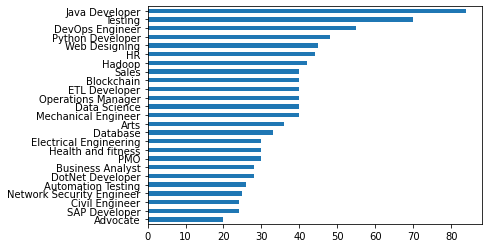

In [23]:
resumes.Category.value_counts().sort_values().plot(kind='barh')

In [38]:
# export charts to HTML
EXPORT_HTML = False

if EXPORT_HTML:
    fig_ts.write_html("apps_timeseries.html", include_plotlyjs="cdn")
    fig_bar.write_html("apps_grouped_bar.html", include_plotlyjs="cdn")
    fig_funnel.write_html("pipeline_funnel.html", include_plotlyjs="cdn")
    print("Exported HTML files")

## Supplementary

In [36]:
terms = {'Quality/Six Sigma':['black belt','capability analysis','control charts','doe','dmaic','fishbone',
                              'gage r&r', 'green belt','ishikawa','iso','kaizen','kpi','lean','metrics',
                              'pdsa','performance improvement','process improvement','quality',
                              'quality circles','quality tools','root cause','six sigma',
                              'stability analysis','statistical analysis','tqm'],      
        'Operations management':['automation','bottleneck','constraints','cycle time','efficiency','fmea',
                                 'machinery','maintenance','manufacture','line balancing','oee','operations',
                                 'operations research','optimization','overall equipment effectiveness',
                                 'pfmea','process','process mapping','production','resources','safety',
                                 'stoppage','value stream mapping','utilization'],
        'Supply chain':['abc analysis','apics','customer','customs','delivery','distribution','eoq','epq',
                        'fleet','forecast','inventory','logistic','materials','outsourcing','procurement',
                        'reorder point','rout','safety stock','scheduling','shipping','stock','suppliers',
                        'third party logistics','transport','transportation','traffic','supply chain',
                        'vendor','warehouse','wip','work in progress'],
        'Project management':['administration','agile','budget','cost','direction','feasibility analysis',
                              'finance','kanban','leader','leadership','management','milestones','planning',
                              'pmi','pmp','problem','project','risk','schedule','scrum','stakeholders'],
        'Data analytics':['analytics','api','aws','big data','busines intelligence','clustering','code',
                          'coding','data','database','data mining','data science','deep learning','hadoop',
                          'hypothesis test','iot','internet','machine learning','modeling','nosql','nlp',
                          'predictive','programming','python','r','sql','tableau','text mining',
                          'visualuzation'],
        'Healthcare':['adverse events','care','clinic','cphq','ergonomics','healthcare',
                      'health care','health','hospital','human factors','medical','near misses',
                      'patient','reporting system']}

# Initializie score counters for each area
quality = 0
operations = 0
supplychain = 0
project = 0
data = 0
healthcare = 0

# Create an empty list where the scores will be stored
scores = []

# Obtain the scores for each area
for area in terms.keys():
        
    if area == 'Quality/Six Sigma':
        for word in terms[area]:
            if word in text:
                quality +=1
        scores.append(quality)
        
    elif area == 'Operations management':
        for word in terms[area]:
            if word in text:
                operations +=1
        scores.append(operations)
        
    elif area == 'Supply chain':
        for word in terms[area]:
            if word in text:
                supplychain +=1
        scores.append(supplychain)
        
    elif area == 'Project management':
        for word in terms[area]:
            if word in text:
                project +=1
        scores.append(project)
        
    elif area == 'Data analytics':
        for word in terms[area]:
            if word in text:
                data +=1
        scores.append(data)
        
    else:
        for word in terms[area]:
            if word in text:
                healthcare +=1
        scores.append(healthcare)

In [ ]:
#en fin